In [1]:
import pandas as pd

df= pd.read_json('news_dataset.json')
print(df.shape)
df.head()

(12695, 2)


,text,category
0,Watching Schrödinger's Cat Die University of C...,SCIENCE
1,WATCH: Freaky Vortex Opens Up In Flooded Lake,SCIENCE
2,Entrepreneurs Today Don't Need a Big Budget to...,BUSINESS
3,These Roads Could Recharge Your Electric Car A...,BUSINESS
4,Civilian 'Guard' Fires Gun While 'Protecting' ...,CRIME


In [2]:
df.category.value_counts()

category
BUSINESS    4254
SPORTS      4167
CRIME       2893
SCIENCE     1381
Name: count, dtype: int64

**Handling imbalanced dataset using Undersampling**

In [3]:
min_samples= 1381         #SCIENCE is the minority class

df_business=df[df.category=="BUSINESS"].sample(min_samples,random_state=0)
df_sports=df[df.category=="SPORTS"].sample(min_samples,random_state=0)
df_crime=df[df.category=="CRIME"].sample(min_samples,random_state=0)
df_science=df[df.category=="SCIENCE"].sample(min_samples,random_state=0)

In [4]:
df_balanced= pd.concat([df_business,df_sports,df_crime,df_science],axis=0)
df_balanced.category.value_counts()

category
BUSINESS    1381
SPORTS      1381
CRIME       1381
SCIENCE     1381
Name: count, dtype: int64

**Convert text category to number**

In [5]:
df_balanced['category_num']=df_balanced.category.map({
    'BUSINESS':0,
    'SPORTS':1,
    'CRIME':2,
    'SCIENCE':4
})

In [6]:
df_balanced.head()

,text,category,category_num
5790,Recycling Opens the Door to a Circular Economy...,BUSINESS,0
6168,Beyond Silicon Valley: Using a MOOC to Build a...,BUSINESS,0
2965,Obstacles for Women in Business: The Comfort P...,BUSINESS,0
9320,Tesla Investigating Second Reported Crash In A...,BUSINESS,0
3743,The Places That Most Desperately Need A Higher...,BUSINESS,0


**Build a model with original text, no preprocessing**

In [7]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test= train_test_split(
    df_balanced.text,
    df_balanced.category_num,
    test_size=0.2,
    random_state=0,
    stratify=df_balanced.category_num
)

**Attempt 1 : Use 1-gram Bag Of Words (BOW) Model**

In [8]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report

#Create a pipeline object
clf= Pipeline([
    ('vectorizer_bow',CountVectorizer(ngram_range=(1,1))),
    ('Multi NB',MultinomialNB())
])

#2. fit with X_train and y_train
clf.fit(X_train,y_train)

#3. print the classification report
y_pred= clf.predict(X_test)

#4. print the classificatio report
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.79      0.87      0.83       277
           1       0.90      0.83      0.86       276
           2       0.88      0.90      0.89       276
           4       0.86      0.82      0.84       276

    accuracy                           0.86      1105
   macro avg       0.86      0.86      0.86      1105
weighted avg       0.86      0.86      0.86      1105



**Attempt 2 : Using 1-gram and bigrams**

In [9]:
#1. create a pipeline object
clf=Pipeline([
    ('vectorizer_1_2_grams',CountVectorizer(ngram_range=(1,2))),
    ('Multi NB',MultinomialNB())
])

#2. fit with X_train and y_train
clf.fit(X_train,y_train)

#3. get the predictions for X_test and store it in y_pred
y_pred= clf.predict(X_test)

#4. print the classification report
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.71      0.91      0.80       277
           1       0.92      0.78      0.84       276
           2       0.89      0.90      0.89       276
           4       0.87      0.76      0.81       276

    accuracy                           0.84      1105
   macro avg       0.85      0.84      0.84      1105
weighted avg       0.85      0.84      0.84      1105



**Attempt 3 : Use 1-grams to trigrams**

In [10]:
#1. create a pipeline object
clf=Pipeline([
    ('vectorizer',CountVectorizer(ngram_range=(1,3))),
    ('Multi NB',MultinomialNB())
])

#2. fit with X_train and y_train
clf.fit(X_train,y_train)

#3. get the predictions for X_test and store it in y_pred
y_pred= clf.predict(X_test)

#4. print the classification report
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.70      0.93      0.80       277
           1       0.93      0.78      0.84       276
           2       0.89      0.89      0.89       276
           4       0.88      0.74      0.81       276

    accuracy                           0.83      1105
   macro avg       0.85      0.83      0.84      1105
weighted avg       0.85      0.83      0.84      1105



**Use text preprocessing to remove stop words, punctuations and apply lemmatization**

In [13]:
import spacy

#load english language model and create nlp object from it
nlp= spacy.load("en_core_web_sm")

In [14]:
def preprocess(text):
    doc= nlp(text)
    filtered_tokens= []
    for token in doc:
        if token.is_stop or token.is_punct:
            continue
        filtered_tokens.append(token.lemma_)
    return " ".join(filtered_tokens)
    

In [15]:
df_balanced['preprocessed_text']= df_balanced.text.apply(preprocess)

In [16]:
df_balanced.head()

,text,category,category_num,preprocessed_text
5790,Recycling Opens the Door to a Circular Economy...,BUSINESS,0,recycle Opens door Circular Economy recycling ...
6168,Beyond Silicon Valley: Using a MOOC to Build a...,BUSINESS,0,Silicon Valley mooc build Community Support Gl...
2965,Obstacles for Women in Business: The Comfort P...,BUSINESS,0,obstacle Women business Comfort Principle cons...
9320,Tesla Investigating Second Reported Crash In A...,BUSINESS,0,Tesla investigate second report Crash Autopilo...
3743,The Places That Most Desperately Need A Higher...,BUSINESS,0,place desperately need high Minimum Wage


**Build a model with preprocessed text**

In [17]:
X_train, X_test, y_train, y_test= train_test_split(
    df_balanced.preprocessed_text,
    df_balanced.category_num,
    test_size=0.2,
    random_state=0,
    stratify= df_balanced.category_num
)

In [28]:
#1. create a pipeline object
clf= Pipeline([
    ('vectorizer',CountVectorizer(ngram_range=(1,2))),
    ('Multi NB',MultinomialNB())
])

#2. fit with X_train and y_train
clf.fit(X_train,y_train)

#3. get the predictions for X_test and store it in y_pred
y_pred= clf.predict(X_test)

#4. print the classification report
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.83      0.87      0.85       277
           1       0.90      0.86      0.88       276
           2       0.86      0.92      0.89       276
           4       0.89      0.83      0.86       276

    accuracy                           0.87      1105
   macro avg       0.87      0.87      0.87      1105
weighted avg       0.87      0.87      0.87      1105



In [30]:
#If you compare above classification report for (1,2) gram with the one from unprocessed text, you will find some improvement in the model that uses preprocessed cleaned up text. Hence we can conclude that for this particular problem using preprocessing (removing stop words, lemmatization) is improving the performance of the model

**Plot confusion matrix**

In [31]:
from sklearn.metrics import confusion_matrix
cm= confusion_matrix(y_test, y_pred)
cm

array([[241,  11,  11,  14],
       [ 11, 237,  20,   8],
       [ 11,   6, 254,   5],
       [ 28,   8,  12, 228]])

Text(58.222222222222214, 0.5, 'Truth')

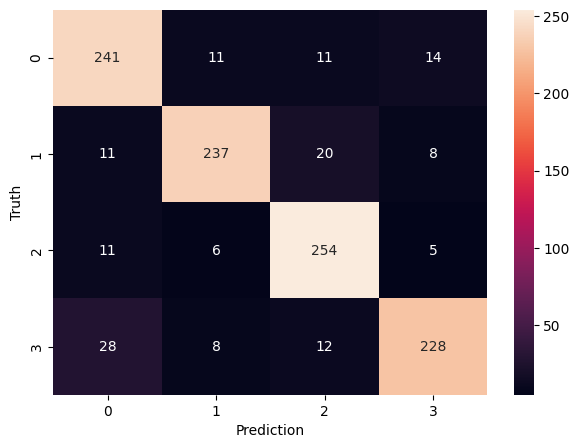

In [37]:
from matplotlib import pyplot as plt
import seaborn as sn
plt.figure(figsize=(7,5))
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Prediction')
plt.ylabel('Truth')